In [22]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [23]:
date = '20230101'
dataNo = 1
scanNo = 1

In [24]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [25]:
columns_sweep = []

for c in scan_data.columns:
    if ~np.all(scan_data[c] == scan_data[c][0]):
        if c[0] == 'A':
            columns_sweep += [c]

columns_sweep

['A0138: LS Freq. 1',
 'A0142: LS amplitude (x) 1',
 'A0143: LS amplitude (y) 1',
 'A0157: OL (H1): AM for physics 2',
 'A0158: OL (H2): AM for physics 2',
 'A0159: OL (H3): AM for physics 2']

In [26]:
param_name_1 = columns_sweep[0]
param_name_2 = columns_sweep[3]
scan_param_1 =scan_data[param_name_1]
scan_param_2 =scan_data[param_name_2]
unique_param_1 = np.sort(scan_param_1.unique())
unique_param_2 = np.sort(scan_param_2.unique())
sample1 = [unique_param_1[0], unique_param_2[0]]
sample2 = [unique_param_1[0], unique_param_2[7]]
sample3 = [unique_param_1[0], unique_param_2[14]]
flcount = scan_data['Total count @ ROI1 (arb. u.)']
logNum = scan_data['Log No.']

In [27]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

In [28]:
imgs_flat =[]
imgs_trans = []

for N in range(len(trans_files)):
    imgs_flat += [np.array(Image.open(flat_files[N]))]
    imgs_trans += [np.array(Image.open(trans_files[N]))]

imgs_trans = np.array(imgs_trans)

img_flat_ave = np.average(imgs_flat, axis=0)
img_trans_ave =np.average(imgs_trans,axis=0) - img_flat_ave

for N in range(len(trans_files)):
    imgs_trans[N, :, :] = imgs_trans[N, :, :] - img_flat_ave

In [73]:
condition1 = [scan_param_1==sample1[0]] and [scan_param_2 ==sample1[1]][0]
condition2 = [scan_param_1==sample2[0]] and [scan_param_2 ==sample2[1]][0]
condition3 = [scan_param_1==sample3[0]] and [scan_param_2 ==sample3[1]][0]

img_trans_sample1 = np.average(imgs_trans[condition1, :, :], axis=0)
img_trans_sample2 = np.average(imgs_trans[condition2, :, :], axis=0)
img_trans_sample3 = np.average(imgs_trans[condition3, :, :], axis=0)

Text(0.5, 1.0, 'A0138: LS Freq. 1 = 1000.0\nA0157: OL (H1): AM for physics 2=6.403')

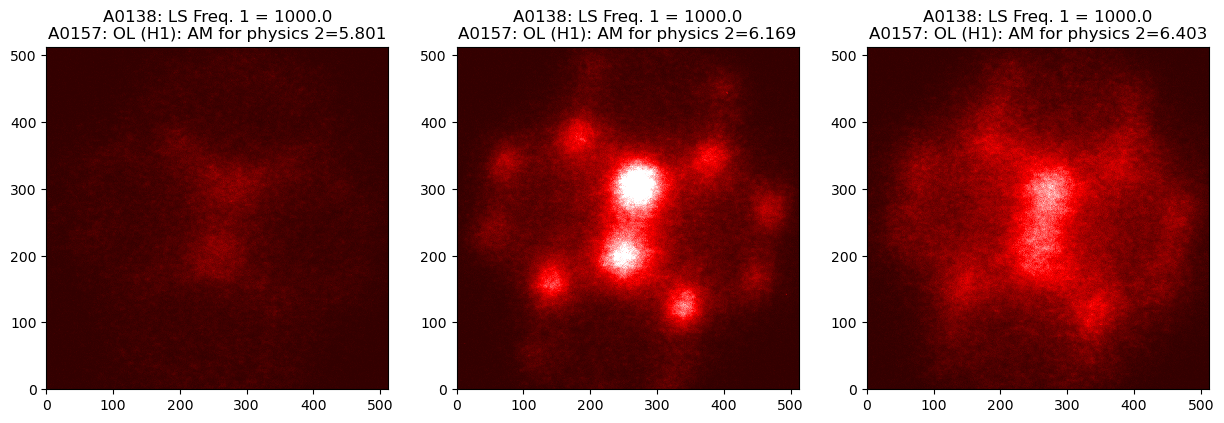

In [77]:
vmin = 0
vmax = 2000
xlim_1 = 0
xlim_2 = np.shape(img_trans_sample1)[0]
ylim_1 = 0
ylim_2 = np.shape(img_trans_sample1)[1]

fig =plt.figure(figsize=[15,10], dpi=100, facecolor="white")
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name_1+ " = %.01f"%(sample1[0])+'\n'+param_name_2+"=%.03f"%(sample1[1]))

ax2 = fig.add_subplot(1,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title(param_name_1+ " = %.01f"%(sample2[0])+'\n'+param_name_2+"=%.03f"%(sample2[1]))

ax3 = fig.add_subplot(1,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title(param_name_1+ " = %.01f"%(sample3[0])+'\n'+param_name_2+"=%.03f"%(sample3[1]))

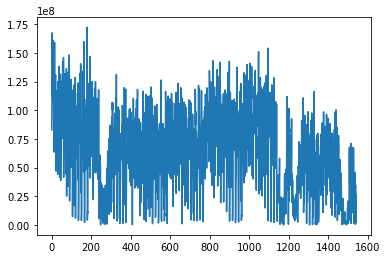

In [78]:
flcount = scan_data['Total count @ ROI1 (arb. u.)']
plt.plot(flcount)

In [79]:
unique_param_indices = [len(unique_param_1)-1,0]

def createUniqueTransFiles(img_trans_list, scan_param_1, scan_param_2, unique_param_1, unique_param_2, unique_param_indices):
    unique_trans_files = []
    for i in range(len(img_trans_list)):
        if scan_param_1[i] == unique_param_1[unique_param_indices[0]] and scan_param_2[i] == unique_param_2[unique_param_indices[1]]:
            unique_trans_files.append(img_trans_list[i])
    return unique_trans_files

unique_trans_files = createUniqueTransFiles(imgs_trans, scan_param_1, scan_param_2, unique_param_1, unique_param_2, unique_param_indices)

In [87]:
cx = 260
cy = 250
shiftx = 5
shifty = 25
r = 35
scalingFacterDependingOnTOF = 2.4
momentum_peaks_C3_dx_list = scalingFacterDependingOnTOF*(shiftx+np.array([0, 79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566]))
momentum_peaks_C3_dy_list = scalingFacterDependingOnTOF*(shifty+np.array([0, -13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663]))
momentum_peaks_C2_dx_list = scalingFacterDependingOnTOF*(-shiftx+np.array([0, 79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566 ]))
momentum_peaks_C2_dy_list = scalingFacterDependingOnTOF*(-shifty+np.array([0, -13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663]))
momentum_peaks_C1_dx_list = scalingFacterDependingOnTOF*np.array([])
momentum_peaks_C1_dy_list = scalingFacterDependingOnTOF*np.array([])
# momentum_peaks_C3_dx_list = scalingFacterDependingOnTOF*np.array([-35.646, 43.6125, -7.9659])
# momentum_peaks_C3_dy_list = scalingFacterDependingOnTOF*np.array([29.7788, 15.980, -45.7598])
# momentum_peaks_C2_dx_list = scalingFacterDependingOnTOF*np.array([35.6872832, -43.6125, 7.9659])
# momentum_peaks_C2_dy_list = scalingFacterDependingOnTOF*np.array([-29.7788, -15.980, 45.7598])
# momentum_peaks_C1_dx_list = scalingFacterDependingOnTOF*np.array([0, 79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566])
# momentum_peaks_C1_dy_list = scalingFacterDependingOnTOF*np.array([0, -13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663])


def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), (momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list, momentum_peaks_C3_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), (momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

c:\Users\hidek\Anaconda3\envs\qgm6\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


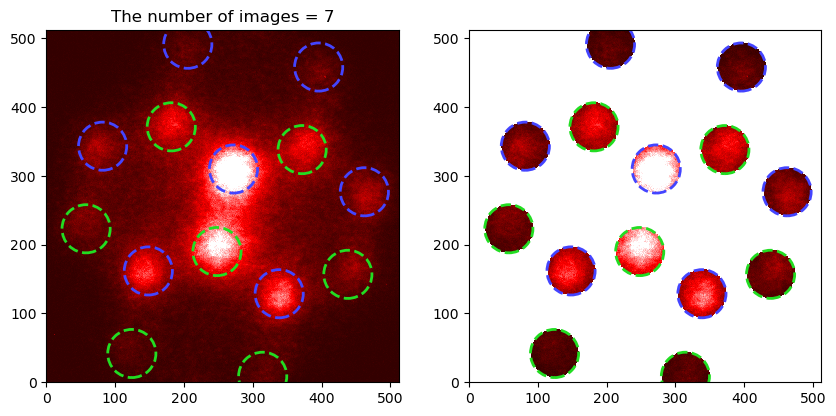

In [89]:
vmin = 0
vmax = 2000
fig =plt.figure(figsize=[10,5],dpi = 100, facecolor="white")
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(img_trans_sample2, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(unique_trans_files)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(subROI_cx_list)):
    ax2.pcolormesh(extractCircleROI(img_trans_sample2, subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i < len(momentum_peaks_C1_dx_list):
        color = '#4444dd'
    elif len(momentum_peaks_C1_dx_list)<=i<len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list):
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=2, linestyle = '--')
    region.plot(ax=ax2, color=color, lw=2, linestyle = '--')

In [90]:
def calculateVisibility(imgs, subROI_cx_list, subROI_cy_list, r):
    row, column = np.shape(imgs_trans[0])
    masks = np.zeros([3, row, column])
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')

    for n_ in range(0, len(momentum_peaks_C1_dx_list), 1):
        d2 = np.square(ii - subROI_cy_list[n_]) + np.square(jj - subROI_cx_list[n_])
        masks[0] += d2 < r * r

    for n_ in range(len(momentum_peaks_C1_dx_list), len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list), 1):
        d2 = np.square(ii - subROI_cy_list[n_]) + np.square(jj - subROI_cx_list[n_])
        masks[1] += d2 < r * r

    for n_ in range(len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list), len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list)+len(momentum_peaks_C3_dx_list), 1):
        d2 = np.square(ii - subROI_cy_list[n_]) + np.square(jj - subROI_cx_list[n_])
        masks[2] += d2 < r * r

    gamma_list = []
    k1_list = []
    k2_list = []
    visibilityOfChirality_list = []

    for img_ in imgs:
        Norm = np.sum(img_)
        gamma_list += [np.sum(img_ * masks[0])/Norm]
        k1_list += [np.sum(img_ * masks[1])/Norm]
        k2_list += [np.sum(img_ * masks[2])/Norm]

        visibilityOfChirality_list.append(k1_list[-1]+k2_list[-1])
    x_list = np.arange(0,len(gamma_list),1)

    return x_list, gamma_list, visibilityOfChirality_list

x_list, gamma_list, contrast_list = calculateVisibility(imgs_trans, subROI_cx_list, subROI_cy_list, r)

In [92]:
contrast_by_unique_param = []
fl_count_by_unique_param = []
sd_contrast_by_unique_param = []
sd_fl_count_by_unique_param = []

for i in range(len(unique_param_1)):
    for j in range(len(unique_param_2)):
        contrast_list_tmp = []
        flcount_list_tmp = []
        for k in range(len(trans_files)):
            if scan_param_1[k]==unique_param_1[i] and scan_param_2[k]==unique_param_2[j]:
                contrast_list_tmp.append(contrast_list[k])
                flcount_list_tmp.append(flcount[k])
        contrast_by_unique_param.append(np.average(contrast_list_tmp))
        fl_count_by_unique_param.append(np.average(flcount_list_tmp))
        sd_contrast_by_unique_param.append(np.std(contrast_list_tmp))
        sd_fl_count_by_unique_param.append(np.std(flcount_list_tmp))

In [93]:
LatticeDepth_list = np.linspace(2.2,5,len(unique_param_2))
Freq_list = np.linspace(1, 1.6, len(unique_param_1))
X, Y = np.meshgrid(LatticeDepth_list, Freq_list)
contrast_array = np.array(contrast_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))
fl_count_array = np.array(fl_count_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))
sd_contrast_array = np.array(sd_contrast_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))
sd_fl_count_array = np.array(sd_fl_count_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))

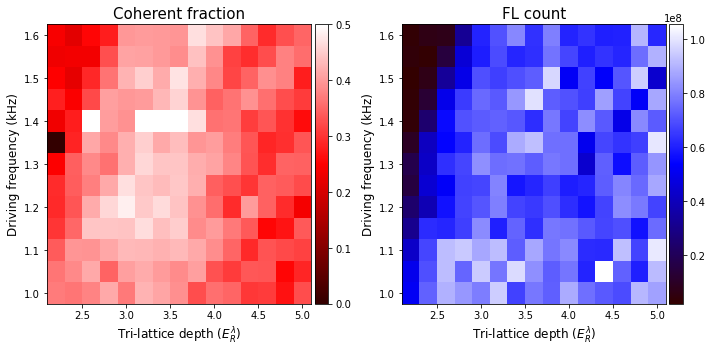

In [101]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = image.generate_cmap(['#330000', 'r', 'w'])
fig =plt.figure(figsize=[10,5], facecolor='white')
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(X,Y,contrast_array, cmap=cmap,vmin=0,vmax=0.5, shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title(r'Coherent fraction', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)

cmap = image.generate_cmap(['#330000', 'b', 'w'])
ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(X,Y,fl_count_array,cmap=cmap, shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('FL count', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)

plt.tight_layout()

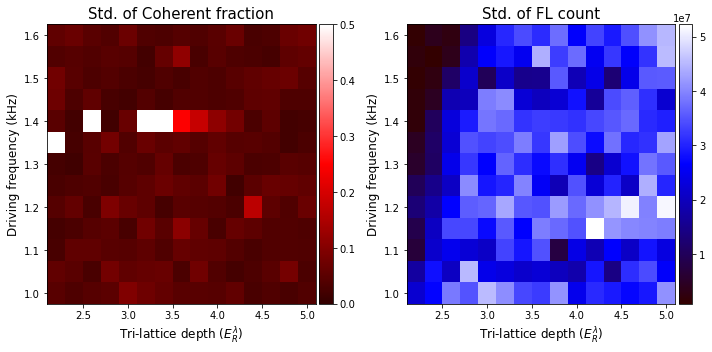

In [103]:
import matplotlib.colors as mcolors

cmap = image.generate_cmap(['#330000', 'r', 'w'])
fig =plt.figure(figsize=[10,5],facecolor='white')
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(X,Y,sd_contrast_array,cmap=cmap,vmin=0,vmax=0.5,shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title(r'Std. of Coherent fraction', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)

cmap = image.generate_cmap(['#330000', 'b', 'w'])
ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(X,Y,sd_fl_count_array,cmap=cmap, shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('Std. of FL count', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)

plt.tight_layout()